<a href="https://colab.research.google.com/github/palakagl/NLP/blob/main/Wysdom_DistilBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This cell installs and sets up DistilBert import, as well as the dataset, which we will 
# use tf.datasets to load (https://www.tensorflow.org/datasets/catalog/overview)

!pip install -q transformers tfds-nightly

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder

try: # this is only working on the 2nd try in colab :)
  from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig, AutoTokenizer, AutoModel, AutoConfig
except Exception as err: # so we catch the error and import it again
  from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig, AutoTokenizer, AutoModel, AutoConfig

import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score

import tensorflow_datasets as tfds

import re

import yellowbrick

In [ ]:
# Mount Google drive so dataset can be accessed
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation

In [ ]:
def load_data(file_path):
  data_df = pd.read_csv(file_path)
  return data_df

orig_data = load_data('/content/drive/MyDrive/Colab Notebooks/data/public_data.csv')
orig_data

,id,message,label
0,10480,start the robotic vacuum,iot_cleaning
1,4210,i am sorry but i think you are not right.,general_negate
2,2443,what is the time difference between california...,datetime_convert
3,5869,tell me my list names,lists_query
4,2801,beep when i get an email from john,email_query
...,...,...,...
8879,9708,search for a train ticket to newcastle,transport_ticket
8880,8278,is there a food festival in the area,recommendation_events
8881,10509,make the lights blue in here,iot_hue_lightchange
8882,7046,play from favorites song,play_music


In [ ]:
orig_data.drop_duplicates(inplace= True)

In [ ]:
orig_data.isna().sum()

id         0
message    0
label      0
dtype: int64

In [ ]:
max_words = []
for row in orig_data['message']:
    max_words.append(len(row.split()))
print(f"The max word count is {np.asarray(max_words).max()}")

The max word count is 25


#Split Data

## Training Data Split

In [ ]:
def extract_text_and_y(df, test_size):

  text = df['message']

  le = LabelEncoder()
  df['label_encoded'] = le.fit_transform(df['label'])
  y = df['label_encoded']

  label_dict = (df[['label','label_encoded']].drop_duplicates()
              .sort_values(by='label_encoded')
              .reset_index(drop=True)['label']
              .to_dict())
  


  X_train, X_val, y_train, y_val = train_test_split(text, y, test_size=test_size, random_state=2)
  return X_train, X_val, y_train, y_val, label_dict

# the following prepares the input for running in DistilBert
train_text, val_text, train_y, val_y, label_dict = extract_text_and_y(orig_data, 0.20)

In [ ]:
train_text

8011    save the information which is provided by aman...
2612                       please raise the lights to max
8642                            the song touches my heart
3724                         yeap you get that perfectly.
4753                                     mute immediately
                              ...                        
1099                                         play my game
2514                                     back one episode
6637         i can't hear you can you say it again louder
2575    tell me about current status of sunderland vs ...
7336                                make this my favorite
Name: message, Length: 7107, dtype: object

In [ ]:
train_y

8011    38
2612    32
8642    38
3724    16
4753     4
        ..
1099    43
2514    45
6637     5
2575    41
7336    38
Name: label_encoded, Length: 7107, dtype: int64

In [ ]:
label_dict

{0: 'alarm_query',
 1: 'alarm_remove',
 2: 'alarm_set',
 3: 'audio_volume_down',
 4: 'audio_volume_mute',
 5: 'audio_volume_up',
 6: 'calendar_query',
 7: 'calendar_remove',
 8: 'calendar_set',
 9: 'cooking_recipe',
 10: 'datetime_convert',
 11: 'datetime_query',
 12: 'email_addcontact',
 13: 'email_query',
 14: 'email_querycontact',
 15: 'email_sendemail',
 16: 'general_affirm',
 17: 'general_commandstop',
 18: 'general_confirm',
 19: 'general_dontcare',
 20: 'general_explain',
 21: 'general_joke',
 22: 'general_negate',
 23: 'general_praise',
 24: 'general_quirky',
 25: 'general_repeat',
 26: 'iot_cleaning',
 27: 'iot_coffee',
 28: 'iot_hue_lightchange',
 29: 'iot_hue_lightdim',
 30: 'iot_hue_lightoff',
 31: 'iot_hue_lighton',
 32: 'iot_hue_lightup',
 33: 'iot_wemo_off',
 34: 'iot_wemo_on',
 35: 'lists_createoradd',
 36: 'lists_query',
 37: 'lists_remove',
 38: 'music_likeness',
 39: 'music_query',
 40: 'music_settings',
 41: 'news_query',
 42: 'play_audiobook',
 43: 'play_game',
 44

### Visualize Data

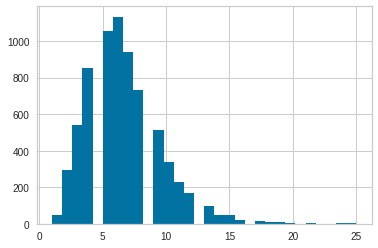

In [ ]:
# Get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

## Creating Embeddings using DistilBERT 

In [ ]:
#Get DistilBERT Tokenizer
#tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased', add_prefix_space=True, use_fast=False)

In [ ]:
# Check longest token sequence in entire text
def checkForMaxTokenSeqInData(text_list, tokenizer_i):
  
    max_val = 0
    for sent in text_list:
        try:
            sent_tok_len = len(tokenizer_i.tokenize(sent))
            max_val = sent_tok_len if (sent_tok_len > max_val) else max_val
        except:
            pass
    
    print(f"The maximum amount of tokens in the dataset is {max_val}")
    return max_val

MAX_VAL = checkForMaxTokenSeqInData(train_text.tolist()+val_text.tolist(),tokenizer)

The maximum amount of tokens in the dataset is 28


In [ ]:

def encode_text(tokenizer_i, text, max_text_length):

    # Encode the sentence
    encodedText = tokenizer_i.batch_encode_plus(
        text,  # the sentence to be encoded
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = max_text_length,
        padding='max_length',
        truncation=True
        )
    # Get the input IDs and attention mask in tensor format
    input_ids = tf.convert_to_tensor(encodedText['input_ids'])
    attention_mask = tf.convert_to_tensor(encodedText['attention_mask'])
    print(input_ids[0])
    print(tokenizer.convert_ids_to_tokens(input_ids[0]))
    return input_ids, attention_mask

train_input, train_mask = encode_text(tokenizer, train_text, MAX_VAL)
val_input, val_mask = encode_text(tokenizer, val_text, MAX_VAL)

train_model_inputs_and_masks = {
    'inputs' : train_input,
    'masks' : train_mask
}

val_model_inputs_and_masks = {
    'inputs' : val_input,
    'masks' : val_mask
}

tf.Tensor(
[  101  3828  1996  2592  2029  2003  3024  2011 25933  2078  2006  2023
  2299   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(28,), dtype=int32)
['[CLS]', 'save', 'the', 'information', 'which', 'is', 'provided', 'by', 'ama', '##n', 'on', 'this', 'song', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
tf.Tensor(
[  101  2131  2033  1996  2334  3345 10984  2000  7688 20116 21246   102
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(28,), dtype=int32)
['[CLS]', 'get', 'me', 'the', 'local', 'train', 'timing', 'to', 'destination', 'cs', '##tm', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


# Modelling

## Build and Train Model

In [ ]:
def build_model(base_model, trainable=False, params={}):
    inputs = Input(shape = (params['max_seq_length'],),name='input_ids', dtype='int32')
    masks  = Input(shape = (params['max_seq_length'],),name='input_attention', dtype='int32')

    base_model.trainable = trainable

    dbert_output = base_model([inputs, masks])[0]
    cls_token = dbert_output[:, 0, :]
    #dense_layer = Dense(params['dense_layer_1_units'],activation='relu')(dbert_output)
    #dropout_layer = Dropout(params['dropout_rate_1'])(dense_layer)
    #dense_layer = Dense(params['dense_layer_2_units'],activation='relu')(dropout_layer)
    #dropout_layer = Dropout(params['dropout_rate_2'])(dense_layer)
    flatten = Flatten()(cls_token)
    probs = Dense(len(label_dict), activation='softmax', name="output")(flatten)

    model = keras.Model(inputs=[inputs, masks], outputs=probs)
    model.summary()
    return model

MODEL_NAME= 'distilbert-base-uncased'

# Configure DistilBERT's initialization
config = DistilBertConfig(output_hidden_states=True)
                          
# The bare, pre-trained DistilBERT transformer model outputting raw hidden-states 
# and without any specific head on top.
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

params={
        "dense_layer_1_units": 128,        
        "dropout_rate_1": 0.2,
	      "dense_layer_2_units": 32,
        "dropout_rate_2": 0.2,
        "regularizer_l2_rate":0.01,
        "max_seq_length":MAX_VAL
        }

model = build_model(dbert_model, params=params)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 28)]         0           []                               
                                                                                                  
 input_attention (InputLayer)   [(None, 28)]         0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'input_attention[0][0]']        
                                one, 28, 768),                                                    
                                 hidden_states=((No                                         

In [ ]:
def compile_model(model, lr):

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    loss = keras.losses.sparse_categorical_crossentropy
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics='accuracy')
    return model


model = compile_model(model, 0.003)

In [ ]:
# Add Callbacks

# Model Checkpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab Notebooks/Models/NLP/distilBert_text_classification_model_weights.hdf5', save_best_only = True, save_weights_only=True, verbose = 0)

# Early Stopping Checkpoint
EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

In [ ]:
def train_model(model, model_inputs_and_masks_train, model_inputs_and_masks_val,
    y_train, y_val, batch_size, num_epochs):

    # Training Data - Tensor Conversion
    input_ids_train = model_inputs_and_masks_train['inputs']
    attention_masks_train = model_inputs_and_masks_train['masks']
    labels_train = tf.convert_to_tensor(y_train[:])

    # Validation data - Tensor Conversion
    input_ids_val = model_inputs_and_masks_val['inputs']
    attention_masks_val = model_inputs_and_masks_val['masks']
    labels_val = tf.convert_to_tensor(y_val[:])

    # Preparing Training Dataset
    dataset_train = tf.data.Dataset.from_tensors(( (input_ids_train, attention_masks_train), labels_train ))
    dataset_val = tf.data.Dataset.from_tensors(( (input_ids_val, attention_masks_val), labels_val ))

    history = model.fit(dataset_train,
          epochs=num_epochs,
          validation_data=dataset_val,
          batch_size=batch_size, verbose=1,
          callbacks=[tl_checkpoint_1,EarlyStoppingCallback])
    
    return model, history

model, history = train_model(model, train_model_inputs_and_masks, val_model_inputs_and_masks, train_y, val_y, batch_size=32, num_epochs=100)

Epoch 1/100
1/1 [==============================] - 14s 14s/step - loss: 0.6435 - accuracy: 0.8658 - val_loss: 1.4657 - val_accuracy: 0.6066
Epoch 2/100
1/1 [==============================] - 9s 9s/step - loss: 1.4409 - accuracy: 0.6019 - val_loss: 1.1025 - val_accuracy: 0.6691
Epoch 3/100
1/1 [==============================] - 9s 9s/step - loss: 1.0666 - accuracy: 0.6806 - val_loss: 1.2206 - val_accuracy: 0.6387
Epoch 4/100
1/1 [==============================] - 9s 9s/step - loss: 1.1148 - accuracy: 0.6634 - val_loss: 1.2424 - val_accuracy: 0.6607
Epoch 5/100
1/1 [==============================] - 9s 9s/step - loss: 1.1199 - accuracy: 0.6874 - val_loss: 1.0851 - val_accuracy: 0.6989
Epoch 6/100
1/1 [==============================] - 9s 9s/step - loss: 0.9652 - accuracy: 0.7341 - val_loss: 0.9065 - val_accuracy: 0.7462
Epoch 7/100
1/1 [==============================] - 9s 9s/step - loss: 0.8108 - accuracy: 0.7790 - val_loss: 0.8010 - val_accuracy: 0.7738
Epoch 8/100
1/1 [===============

# Predict & Calculate Score

In [ ]:
# Validation data - Tensor Conversion
def predict_labels(model, model_inputs_and_masks_val, y_vals):
  input_ids_val = model_inputs_and_masks_val['inputs']
  attention_masks_val = model_inputs_and_masks_val['masks']
  labels_val = tf.convert_to_tensor(y_vals[:])
  dataset_val = tf.data.Dataset.from_tensors(( (input_ids_val, attention_masks_val), labels_val ))
  output_val = model.predict(dataset_val)
  predicted_labels = np.argmax(output_val, axis=1)
  return predicted_labels

predicted_labels = predict_labels(model, val_model_inputs_and_masks,val_y)
predicted_labels

array([59, 58,  6, ..., 12, 57, 51])

In [ ]:
# Calculate Scores
def calculate_score(val_y, predicted_labels):
  ari_val = adjusted_rand_score(val_y, predicted_labels)
  ami_val = adjusted_mutual_info_score(val_y, predicted_labels, average_method='arithmetic')
  print("ari_val:", ari_val)
  print("ami_val:", ami_val)
  return

calculate_score(val_y, predicted_labels)

ari_val: 0.7276395662824647
ami_val: 0.8163831444172954


#Model Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def run_classification_report(test_y, pred_labels):
  report = classification_report(test_y, pred_labels, output_dict=True)

  df = pd.DataFrame(report)

  df.drop(columns=['accuracy', 'macro avg','weighted avg'], inplace=True)
  df = df.transpose()
  ser = pd.Series(label_dict)

  df = df.assign(Topics=ser.values)
  df.set_index('Topics', inplace=True)
  df=df.round(decimals = 2)
  return df


df= run_classification_report(val_y, predicted_labels)
df

,precision,recall,f1-score,support
Topics,,,,
alarm_query,1.00,0.73,0.84,33.0
alarm_remove,0.86,0.80,0.83,15.0
alarm_set,0.75,0.97,0.85,34.0
audio_volume_down,0.82,0.69,0.75,13.0
audio_volume_mute,0.86,0.86,0.86,37.0
...,...,...,...,...
transport_query,0.90,0.74,0.81,35.0
transport_taxi,0.90,0.90,0.90,31.0
transport_ticket,0.95,0.95,0.95,37.0


#Visualization

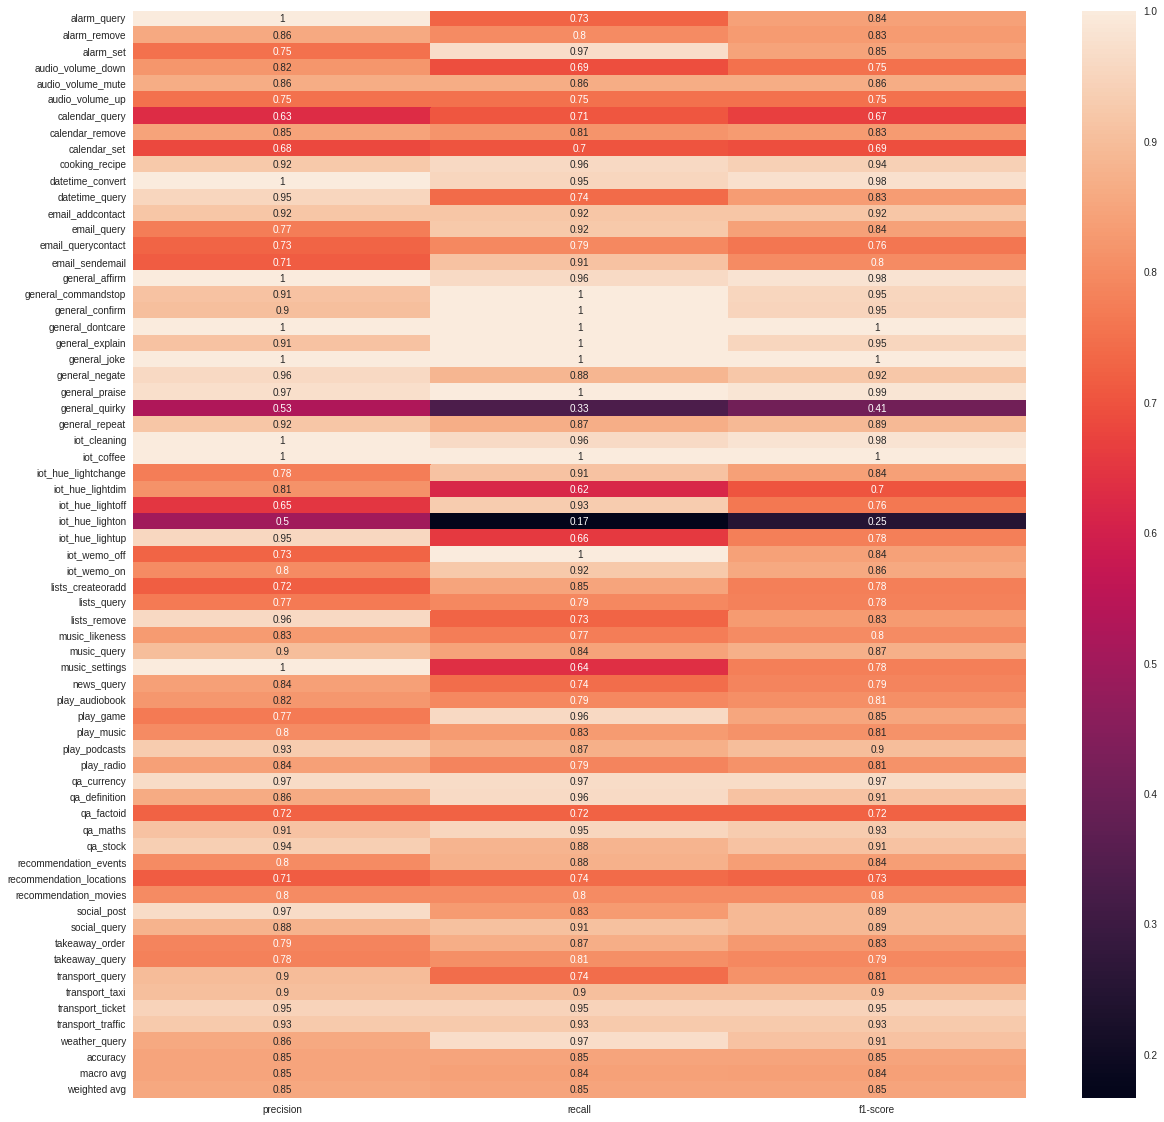

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_classification_report_with_heatmap(test_y, pred_labels, target_names_dict):
  fig, ax = plt.subplots(figsize=(20,20)) 
  clf_report = classification_report(test_y, pred_labels,
                                    target_names=list(target_names_dict.values()),
                                    output_dict=True)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
  return

# Use this dict, if cannot generate from labeled data based dictionary ('label_dict') dynamically
label_dict_fixed={0: 'alarm_query',1: 'alarm_remove',2: 'alarm_set',3: 'audio_volume_down',4: 'audio_volume_mute',5: 'audio_volume_up',6: 'calendar_query',7: 'calendar_remove',8: 'calendar_set',9: 
             'cooking_recipe',10: 'datetime_convert',11: 'datetime_query',12: 'email_addcontact',13: 'email_query',14: 'email_querycontact',15: 'email_sendemail',16: 'general_affirm',17: 'general_commandstop',
             18: 'general_confirm',19: 'general_dontcare',20: 'general_explain',21: 'general_joke',22: 'general_negate',23: 'general_praise',24: 'general_quirky',25: 'general_repeat',26: 'iot_cleaning',
             27: 'iot_coffee',28: 'iot_hue_lightchange',29: 'iot_hue_lightdim',30: 'iot_hue_lightoff',31: 'iot_hue_lighton',32: 'iot_hue_lightup',33: 'iot_wemo_off',34: 'iot_wemo_on',35: 'lists_createoradd',
             36: 'lists_query',37: 'lists_remove',38: 'music_likeness',39: 'music_query',40: 'music_settings',41: 'news_query',42: 'play_audiobook',43: 'play_game',44: 'play_music',45: 'play_podcasts',
             46: 'play_radio',47: 'qa_currency',48: 'qa_definition',49: 'qa_factoid',50: 'qa_maths',51: 'qa_stock',52: 'recommendation_events',53: 'recommendation_locations',54: 'recommendation_movies',
             55: 'social_post',56: 'social_query',57: 'takeaway_order',58: 'takeaway_query',59: 'transport_query',60: 'transport_taxi',61: 'transport_ticket',62: 'transport_traffic',63: 'weather_query'}

visualize_classification_report_with_heatmap(val_y, predicted_labels, label_dict)

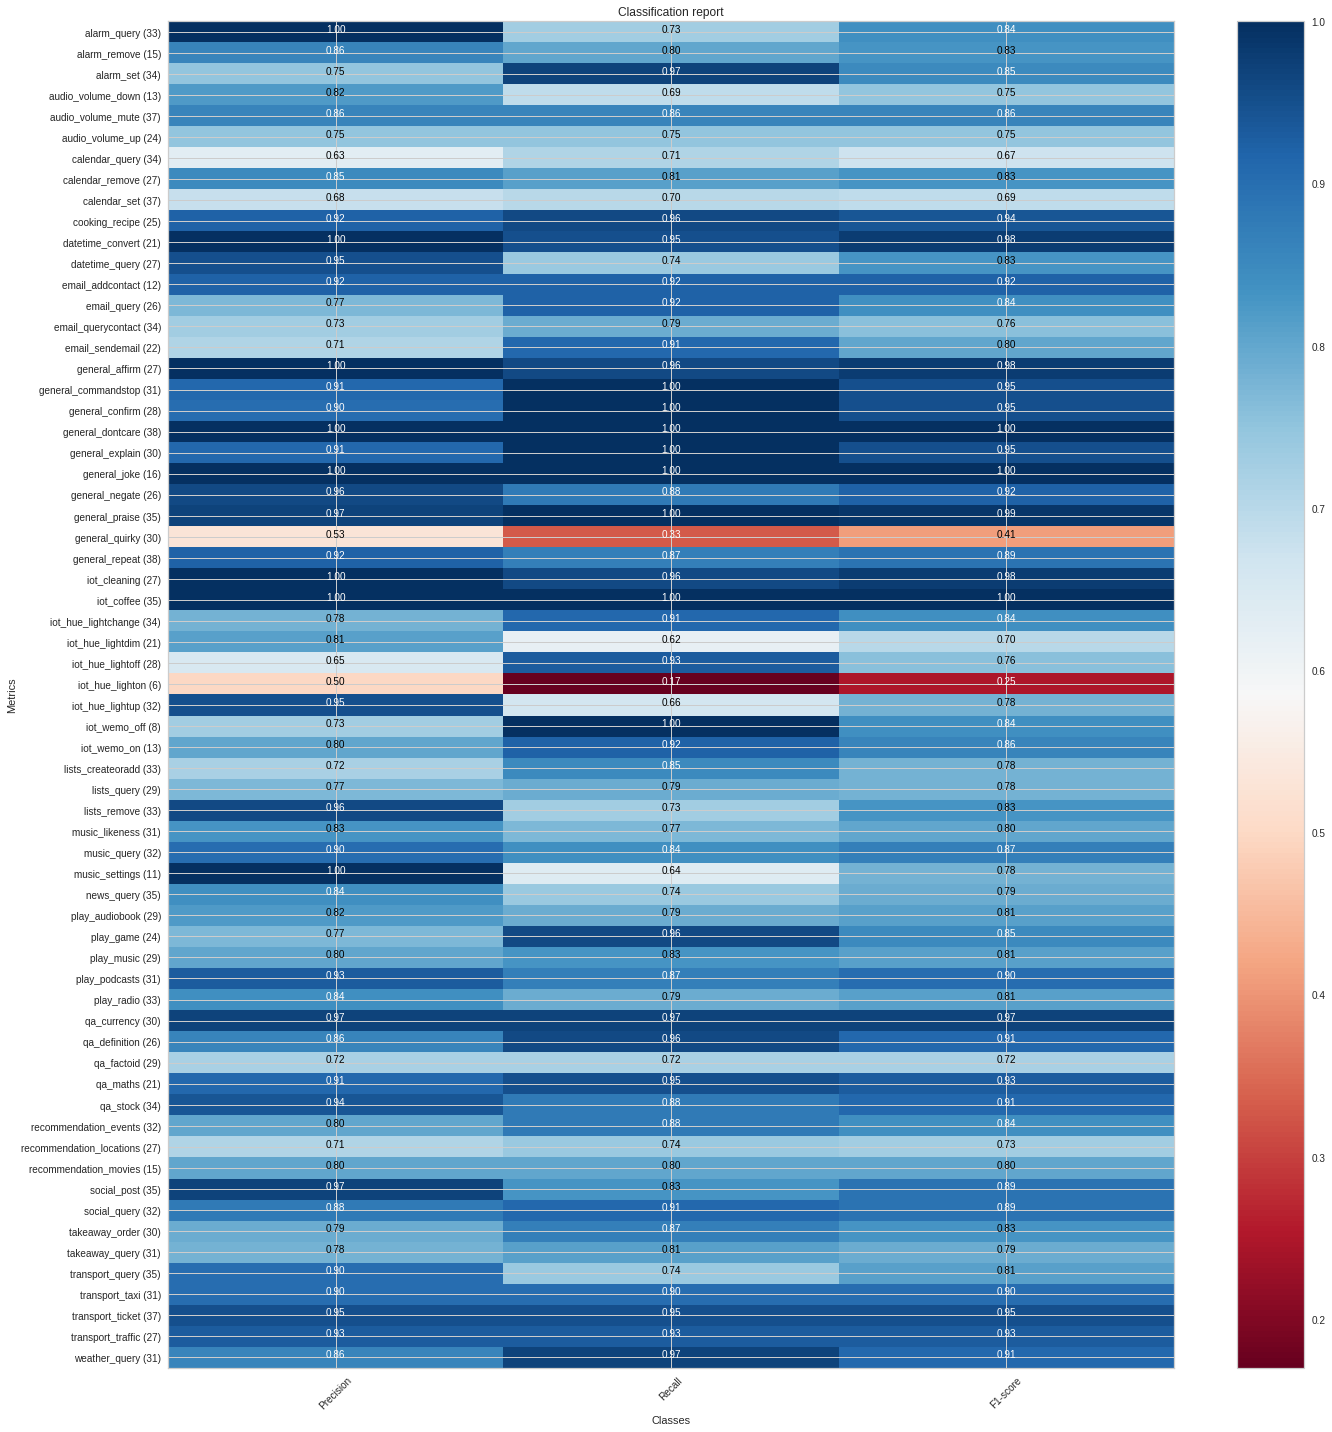

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace('macro avg', 'macro_avg')
    classificationReport = classificationReport.replace('weighted avg', 'weighted_avg')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:-4]:  # if you don't want any avg, then change [1:] into [1:-4]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]
    fig, ax = plt.subplots(figsize=(20,20)) 
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()

# Use this dict, if cannot generate from labeled data based dictionary ('label_dict') dynamically
label_dict_fixed={0: 'alarm_query',1: 'alarm_remove',2: 'alarm_set',3: 'audio_volume_down',4: 'audio_volume_mute',5: 'audio_volume_up',6: 'calendar_query',7: 'calendar_remove',8: 'calendar_set',9: 
             'cooking_recipe',10: 'datetime_convert',11: 'datetime_query',12: 'email_addcontact',13: 'email_query',14: 'email_querycontact',15: 'email_sendemail',16: 'general_affirm',17: 'general_commandstop',
             18: 'general_confirm',19: 'general_dontcare',20: 'general_explain',21: 'general_joke',22: 'general_negate',23: 'general_praise',24: 'general_quirky',25: 'general_repeat',26: 'iot_cleaning',
             27: 'iot_coffee',28: 'iot_hue_lightchange',29: 'iot_hue_lightdim',30: 'iot_hue_lightoff',31: 'iot_hue_lighton',32: 'iot_hue_lightup',33: 'iot_wemo_off',34: 'iot_wemo_on',35: 'lists_createoradd',
             36: 'lists_query',37: 'lists_remove',38: 'music_likeness',39: 'music_query',40: 'music_settings',41: 'news_query',42: 'play_audiobook',43: 'play_game',44: 'play_music',45: 'play_podcasts',
             46: 'play_radio',47: 'qa_currency',48: 'qa_definition',49: 'qa_factoid',50: 'qa_maths',51: 'qa_stock',52: 'recommendation_events',53: 'recommendation_locations',54: 'recommendation_movies',
             55: 'social_post',56: 'social_query',57: 'takeaway_order',58: 'takeaway_query',59: 'transport_query',60: 'transport_taxi',61: 'transport_ticket',62: 'transport_traffic',63: 'weather_query'}

classificationReport = classification_report(val_y, predicted_labels, target_names=list(label_dict.values()))

plot_classification_report(classificationReport)

#Conclusion


1.   Recall is a good inidicator here to tell us how well we have identified topics.
2.   Topics not identified well by model - general_quirky, iot_hue_lighton
3.   'iot_hue_lighton' have very low number of records, compared to other topics, and could be the reason for low recall rate.
4.   'general_quirky' have low recall rate, even with good number of samples. After looking at the data for this topic, looks like conversations under this topic are even confusing for human being. This is why model is performing well.





#Result Submission

In [ ]:
result_df = load_data('/content/drive/MyDrive/Colab Notebooks/data/input_data.csv')
result_df

,id,message
0,10873,list the current price of microsoft shares
1,8491,where is the nearest smoke shop
2,4549,please start over.
3,5948,read my lists to me
4,1663,mute volume now
...,...,...
2216,10368,what you have said was not so clear to me.
2217,6320,what is the name of the artist that created th...
2218,5347,please shut off the kitchen lights
2219,2848,update on email


In [ ]:
def predict_test_data():
  test_text = result_df['message']

  test_input, test_mask = encode_text(tokenizer, test_text, MAX_VAL)
  y_label = pd.Series([])
  test_model_inputs_and_masks = {
      'inputs' : test_input,
      'masks' : test_mask
  }
  dataset_val = tf.data.Dataset.from_tensors(( (test_input, test_mask), y_label))
  output_val = model.predict(dataset_val)
  predicted_labels = np.argmax(output_val, axis=1)
  return predicted_labels

predicted_labels=predict_test_data()

tf.Tensor(
[ 101 2862 1996 2783 3976 1997 7513 6661  102    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0], shape=(28,), dtype=int32)
['[CLS]', 'list', 'the', 'current', 'price', 'of', 'microsoft', 'shares', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


In [ ]:
# Save Test Data predictions to csv
my_submission = pd.DataFrame({'Id': result_df['id'], 'label': predicted_labels})
my_submission['label'] = my_submission['label'].map(label_dict)
print(my_submission.head())

my_submission.to_csv('/content/drive/MyDrive/Colab Notebooks/data/submission_custom_distillbert.csv', index=False)

      Id                     label
0  10873                  qa_stock
1   8491  recommendation_locations
2   4549            general_repeat
3   5948               lists_query
4   1663         audio_volume_mute


#Fine Tuning Custom DistilBERT Model

In [ ]:
# Unfreeze distilBERT layers and make available for training
def fine_tune_transfer_learning_model(base_transfomer_model, custom_model, learning_rate):

    base_transfomer_model.trainable = True
    
    # Recompile model after unfreezing
    model_updated = compile_model(custom_model, learning_rate)
    custom_model.summary()
    
    model_updated, history2 = train_model(model_updated, train_model_inputs_and_masks, val_model_inputs_and_masks, train_y, val_y, batch_size=16, num_epochs=5)

    return custom_model, history2

model2, history2=fine_tune_transfer_learning_model(dbert_model, model, 1e-5)